# Generate a bootstrap method for the fdac package

In [1]:
#imports 
import numpy as np
import random as rand
import matplotlib.pyplot as plt
import pandas as pd
from random import gauss

In [2]:
import scienceplots
plt.style.use(['science','notebook','grid'])
plt.rcParams['text.usetex'] = True
plt.rcParams.update({"font.size" : 26})
plt.rcParams.update({"axes.labelsize" : 24})
plt.rcParams.update({"xtick.labelsize" : 22})
plt.rcParams.update({"ytick.labelsize" : 22})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

### Generate fake data that has a sinusoid with some noise

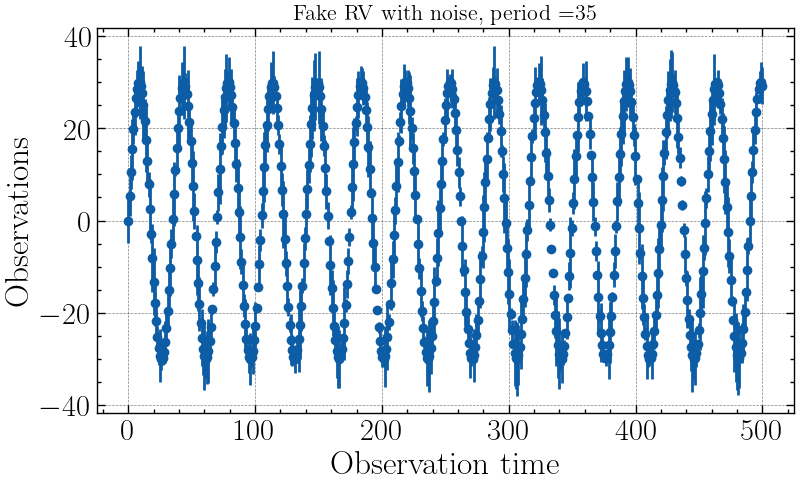

In [3]:
#fake rv
np.random.seed(100)

nobs = 500
time = np.linspace(0, 500,500)
period = 35
#perio 20
ampl = 30
sine = ampl*np.sin(2*np.pi*time/period)
noise = 2*np.random.normal(0,10,500)
# noise = *np.random.normal(0,10,500)
f_rv = sine
f_erv = 0.4*np.random.uniform(high = 20, size = nobs)

plt.figure(figsize=(9,5))
plt.errorbar(time, f_rv, yerr = f_erv, fmt = 'o')
plt.xlabel('Observation time')
plt.ylabel('Observations')
plt.title('Fake RV with noise, period =35')
plt.savefig('figures/fake_rv.png')

### Generate an activity indictator time series with the same period but phase shifted by $\pi/2$

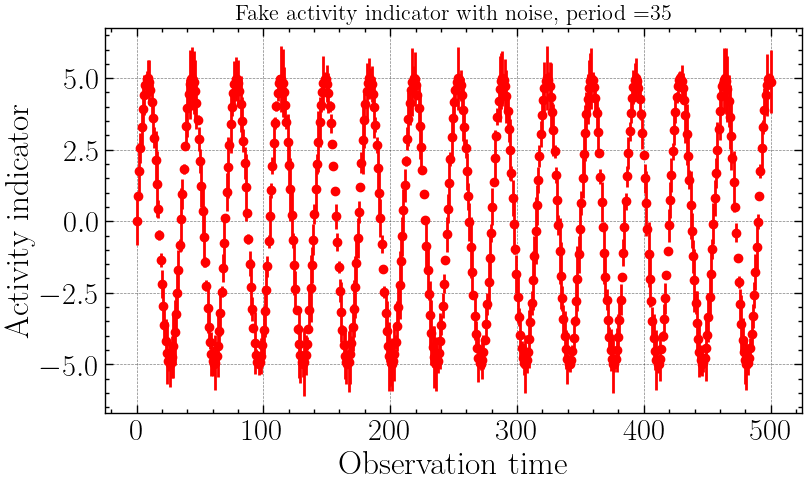

In [4]:
cosine = 5*np.sin(2*np.pi*time/period)
noise2 = np.random.normal(0,1.5, nobs)
act = cosine 
#act = cosine + noise2
err_act = 0.3*np.random.uniform(high = 4, size = nobs)

plt.figure(figsize=(9,5))
plt.errorbar(time, act, yerr = err_act,color= 'r', fmt = 'o')
plt.xlabel('Observation time')
plt.ylabel('Activity indicator')
plt.title('Fake activity indicator with noise, period =35')
plt.savefig('figures/fak_activity.png')

### Generate a way to create similar time series, assuming normal distribution around the error bars

<ErrorbarContainer object of 3 artists>

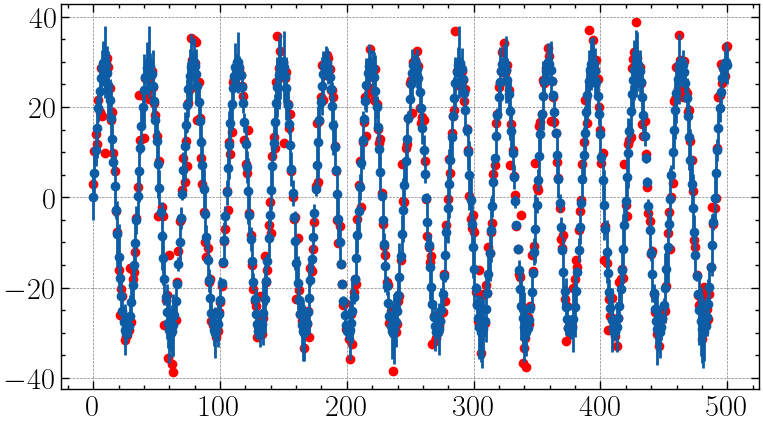

In [5]:
#make random distribution
numbers = np.random.normal(size = len(f_rv))
new_data = f_erv * numbers + f_rv

plt.figure(figsize=(9,5))
plt.plot(time, new_data, 'o', color = 'r')
plt.errorbar(time, f_rv, yerr = f_erv, fmt = 'o')

### Generate similar time series by using loops rather than matrices 

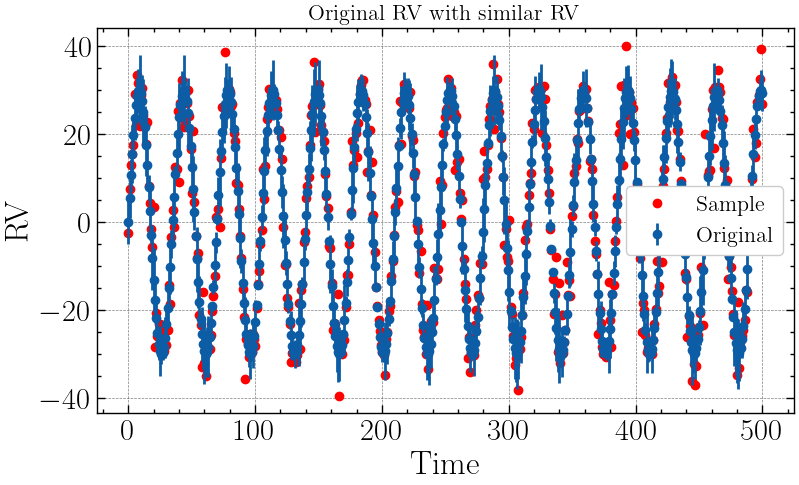

In [6]:
test = np.zeros(len(f_rv))
for i in range(len(f_rv)):
    test[i] = np.random.normal() *f_erv[i] + f_rv[i]
    

plt.figure(figsize=(9,5))
plt.plot(time, test, 'o', color = 'r', label='Sample')
plt.xlabel('Time')
plt.ylabel('RV')
plt.title('Original RV with similar RV')
plt.errorbar(time, f_rv, yerr = f_erv, fmt = 'o', label='Original')
plt.legend()

Looks very good! Now to do a whole lot of them

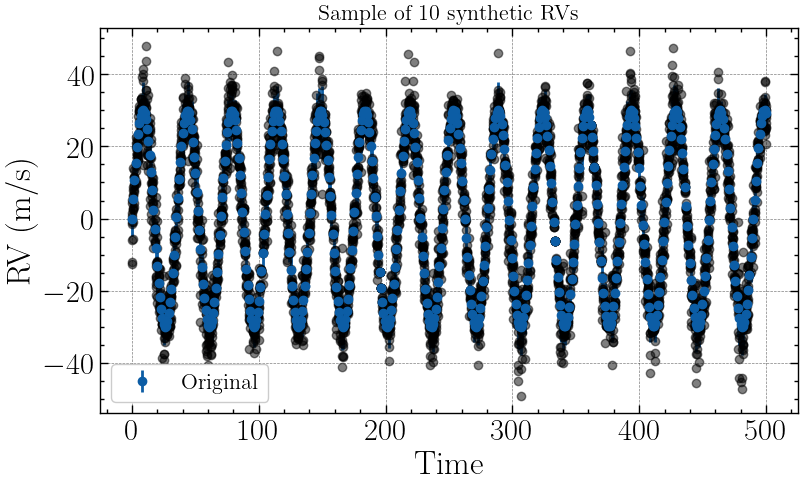

In [7]:
nboot = 1000
prueba= np.zeros((nboot,len(f_rv)))

for j in range(nboot):
    for i in range(len(f_rv)):
        prueba[j,i] = np.random.normal() *f_erv[i] + f_rv[i]
    

plt.figure(figsize=(9,5)) #plot only ten of them
plt.xlabel('Time')
plt.ylabel('RV (m/s)')
plt.title('Sample of 10 synthetic RVs')
plt.errorbar(time, f_rv, yerr = f_erv, fmt = 'o', label='Original')
for i in range(10):
    plt.plot(time, prueba[i, :], 'o', color = 'k', alpha = 0.5)
plt.legend()
#plt.savefig('figures/syntheticrvs.png')

So far so good, now time to make the FFTs of all the bootstrap RVs

## Scale the Observations to unit variances

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
scaled_rv = (f_rv - np.mean(f_rv)) / np.std(f_rv)
scaled_ac = (act - np.mean(act)) / np.std(act)
array_scaled = StandardScaler().fit_transform(prueba.T)

### Now try making FFTs

To do so I run the finufft package for each generated RVs using the normla distribution and I stored them in an $n\times m$ matrix where $n$ is the number of bootstraps and $m$ is the lenght of the frequency grid.

$$\begin{bmatrix} \mathcal{F}_{11} & \mathcal{F}_{12} & ... & \mathcal{F}_{1 m} \\ \mathcal{F}_{21} & \mathcal{F}_{22} & ... & \mathcal{F}_{2 m} \\ \vdots & \vdots & \vdots & \vdots \\\mathcal{F}_{n1} & \mathcal{F}_{n2} & ... & \mathcal{F}_{n m} \end{bmatrix}$$

In [13]:
from finufft import nufft1d3
nyq = 0.5/np.mean(np.diff(time))
maxf = nyq      # Maximum frequency is 2x the Nyquist frequency
nr = len(time)
nf = 2*nr + 1
fgrid = np.linspace(-maxf, maxf, num= nf, endpoint=True)  #create the frequency grid

#original rv fft
fft_val = nufft1d3(2*np.pi*time, scaled_rv.astype(complex), fgrid, isign=-1, nthreads=1, eps = 1e-14)

In [14]:
#generate the nxm matrix that hols
ffts = np.zeros((nboot, len(fft_val)), dtype = complex)

for i in range(nboot):
    ffts[i,:] = nufft1d3(2*np.pi*time, array_scaled[:,i].astype(complex) , fgrid, isign=-1, nthreads=1, eps=1e-14)

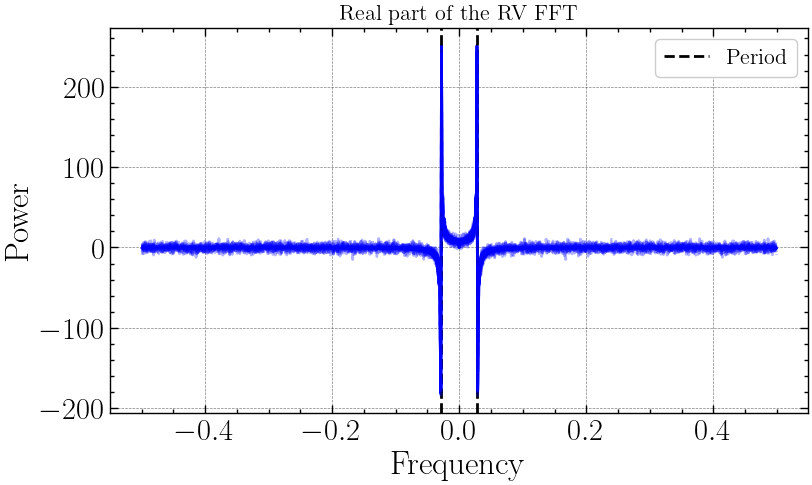

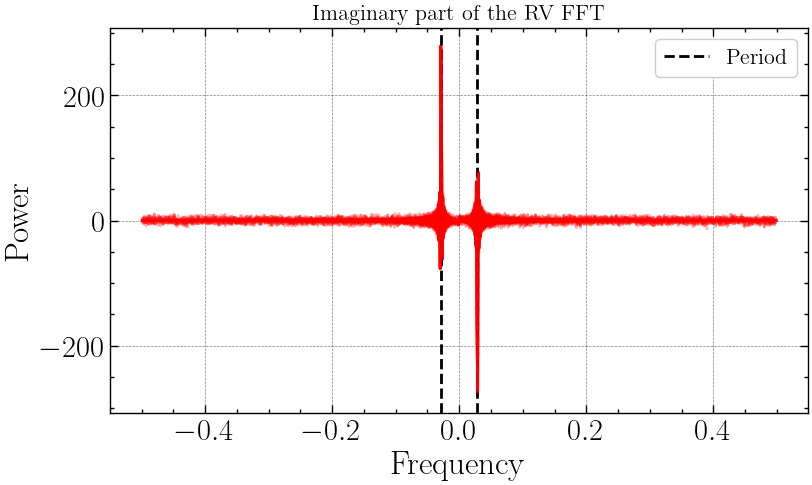

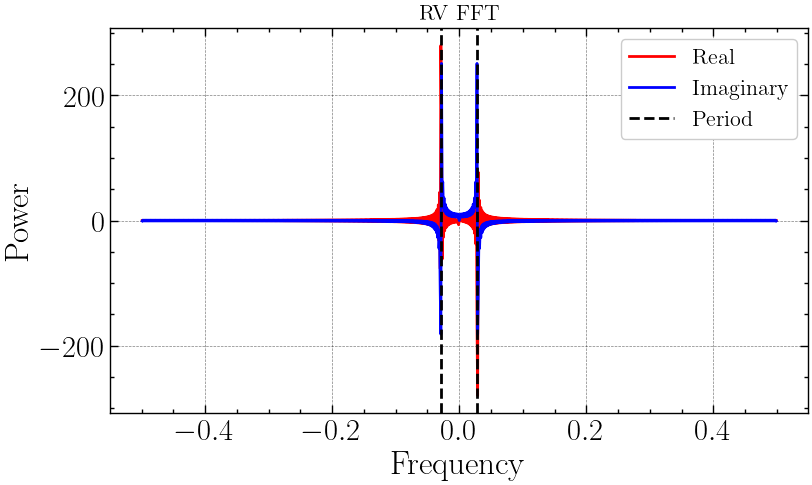

In [15]:
# chekc the results

plt.figure(figsize = (9,5))
plt.plot(fgrid, fft_val.real, color = 'b')
#plt.plot(fgrid, fft_val.imag, color= 'r')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Real part of the RV FFT')
plt.axvline(1/period, color='k', linestyle='--', label ='Period')
plt.axvline(-1/period, color='k', linestyle='--')
for i in range(10):
    plt.plot(fgrid, ffts[i, :].real, linestyle= '--', color = 'b' , alpha = 0.3)
    #plt.plot(fgrid, ffts[i, :].imag, linestyle = '--', color= 'r', alpha = 0.3)
plt.legend()
plt.savefig('figures/realfft_rv.png')

plt.figure(figsize = (9,5))
plt.plot(fgrid, fft_val.imag, color= 'r')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Imaginary part of the RV FFT')
plt.axvline(1/period, color='k', linestyle='--', label ='Period')
plt.axvline(-1/period, color='k', linestyle='--')
for i in range(10):
    plt.plot(fgrid, ffts[i, :].imag, linestyle = '--', color= 'r', alpha = 0.3)
plt.legend()
plt.savefig('figures/imagfft_rv.png')

plt.figure(figsize = (9,5))
plt.plot(fgrid, fft_val.imag, color= 'r', label = 'Real')
plt.plot(fgrid, fft_val.real, color= 'b', label = 'Imaginary')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('RV FFT')
plt.axvline(1/period, color='k', linestyle='--', label ='Period')
plt.axvline(-1/period, color='k', linestyle='--')
plt.legend()
plt.savefig('figures/fft_rv.png')

I wonder why the imaginary part has those very large peaks close to the 0th frequency and at 1

### Now calculate the standard deviation of each frequency value by using the bootsrap RVs

<ErrorbarContainer object of 3 artists>

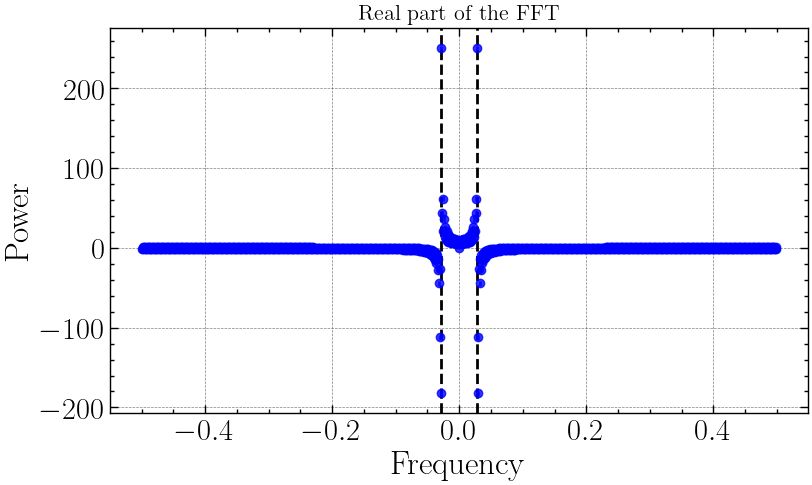

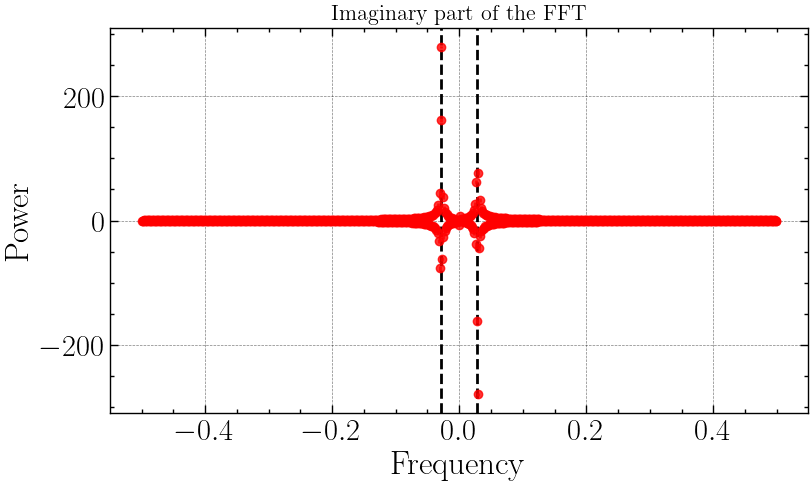

In [16]:
#estimate the standard deviation for each frequency value
stdfft_real = np.zeros(len(fft_val))
stdfft_imag = np.zeros(len(fft_val))


for i in range(len(fft_val)):
    stdfft_real[i] = np.std(ffts.real[:,i])
    stdfft_imag[i] = np.std(ffts.imag[:,i])

plt.figure(figsize=(9,5))
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Real part of the FFT')
plt.axvline(1/period, color='k', linestyle='--', label ='Period')
plt.axvline(-1/period, color='k', linestyle='--')
plt.errorbar(fgrid, fft_val.real ,fmt = 'o', yerr = stdfft_real, color = 'b', alpha = 0.8)
#plt.fill_between(fgrid, fft_val.real - fft_err_real, fft_val.real + fft_err_real, alpha = 0.5 )

plt.figure(figsize=(9,5))
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Imaginary part of the FFT')
plt.axvline(1/period, color='k', linestyle='--', label ='Period')
plt.axvline(-1/period, color='k', linestyle='--')
plt.errorbar(fgrid, fft_val.imag,fmt = 'o',  yerr = stdfft_imag, color = 'r', alpha = 0.8)

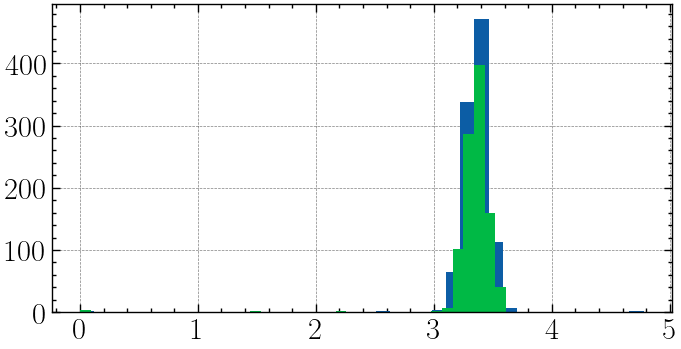

In [17]:
# make a histogram to see the distribution of the value for the standar deviation at each frequnecy
plt.figure(figsize=(8,4))
plt.hist(stdfft_real, 40);
plt.hist(stdfft_imag, 40);

#### Seems to work!
Now on to try with the activity model

In [18]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

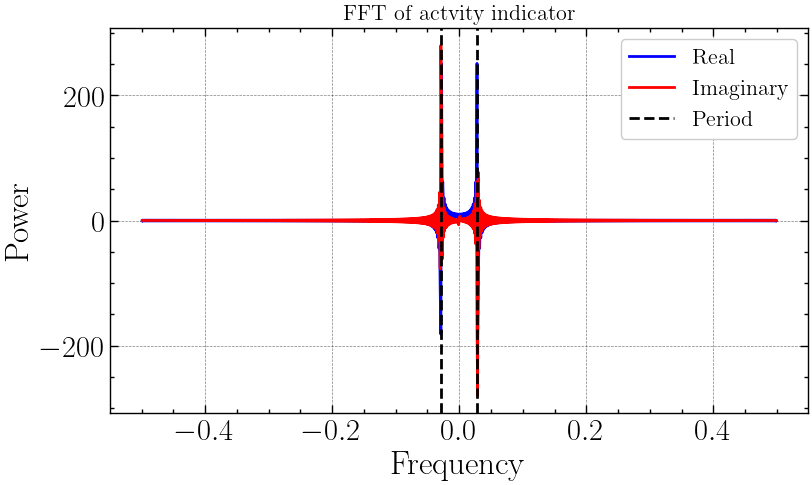

In [19]:
#perform fft of activity indicator
fft_act = nufft1d3(2*np.pi*time, scaled_ac.astype(complex), fgrid, isign=-1, nthreads=1)

plt.figure(figsize=(9,5))
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('FFT of actvity indicator')
plt.plot(fgrid, fft_act.real, label = 'Real', color = 'b')
plt.plot(fgrid, fft_act.imag, label = 'Imaginary', color = 'r')
plt.axvline(1/period, color='k', linestyle='--', label ='Period')
plt.axvline(-1/period, color='k', linestyle='--')
plt.legend()

## Perform the linear regression on the RV FFT 

 **This is where I suspect an error in the code**

In [20]:
activity_fre =np.array((fft_act.real,fft_act.imag)).T
activity_fre.shape

(1001, 2)

In [21]:
fft_act.imag

array([-5.16218552e-08,  1.99754279e-03, -4.11406360e-03, ...,
        4.11406360e-03, -1.99754279e-03, -2.01994512e-06])

In [22]:
#perform the fft of the actual data and trying using error bars from the previous bootstrap

reg_real = linear_model.Ridge()
reg_real.fit(activity_fre, fft_val.real)
ac_real = reg_real.predict(activity_fre)
print('Real')
print('----')
print('Intercept: \n', reg_real.intercept_)
print('Coefficients: \n', reg_real.coef_)

reg_imag = linear_model.Ridge()
reg_imag.fit(activity_fre, fft_val.imag)
ac_imag = reg_imag.predict(activity_fre)
print('Imaginary')
print('----')
print('Intercept: \n', reg_imag.intercept_)
print('Coefficients: \n', reg_imag.coef_)

Real
----
Intercept: 
 -1.1932073249246167e-07
Coefficients: 
 [9.99996099e-01 3.05937698e-11]
Imaginary
----
Intercept: 
 1.3616845674388186e-08
Coefficients: 
 [-2.77972074e-11  9.99995927e-01]


In [23]:
ac_real.max()

251.27538938821274

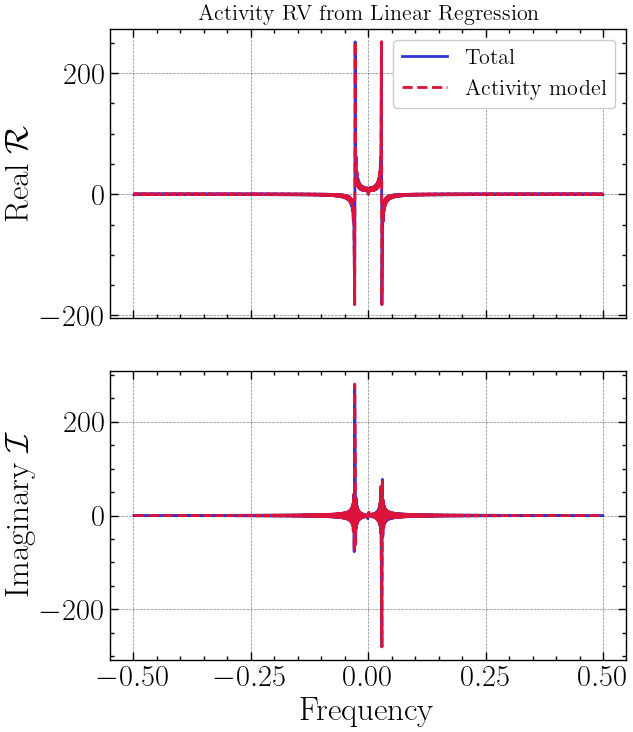

In [24]:
#plot the linear regression activity model
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7,8))
ax1.plot(fgrid, fft_val.real, label="Total ", color='mediumblue', alpha = 0.8)
ax1.plot(fgrid, ac_real, '--', label="Activity model", color='crimson')
ax1.legend(loc="best")
ax1.set_ylabel(r"Real $\mathcal{R}$")
ax1.set_title("Activity RV from Linear Regression")
ax2.plot(fgrid, fft_val.imag, color='mediumblue', alpha = 0.8)
ax2.plot(fgrid, ac_imag, '--', color='crimson')
ax2.set_ylabel(r"Imaginary $\mathcal{I}$")
ax2.set_xlabel("Frequency")
plt.tight_layout()
#plt.savefig('figures/fftmodel.png')

When they are in phase the results are in agreement

#### seems like I need to apply the normalization using Parseval's theorem

In [25]:
#now do it for the bootstrap RVs
#real
acmodel_real = np.zeros((nboot,len(fft_val)))
acmodel_imag = np.zeros((nboot,len(fft_val)))
intercepts= np.zeros((nboot,2))
coefficients_real= np.zeros((nboot,2))
coefficients_imag= np.zeros((nboot,2))

for i in range(nboot):
    #real
    boot_reg_real = linear_model.LinearRegression()
    boot_reg_real.fit(activity_fre, ffts[i,:].real)
    acmodel_real[i,:] = boot_reg_real.predict(activity_fre)
    intercepts[i,0]= boot_reg_real.intercept_
    coefficients_real[i,:] = boot_reg_real.coef_
    
    #imag
    boot_reg_imag = linear_model.LinearRegression()
    boot_reg_imag.fit(activity_fre, ffts[i,:].imag)
    acmodel_imag[i,:] = boot_reg_real.predict(activity_fre)
    intercepts[i,1]= boot_reg_imag.intercept_
    coefficients_imag[i,:] = boot_reg_imag.coef_

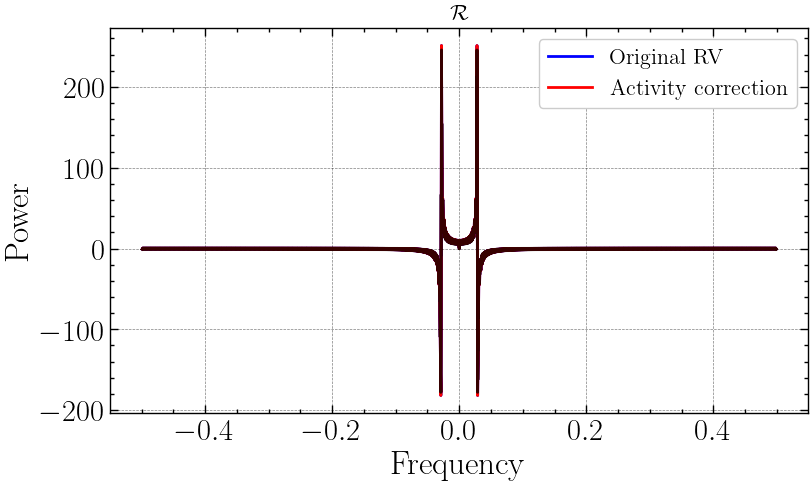

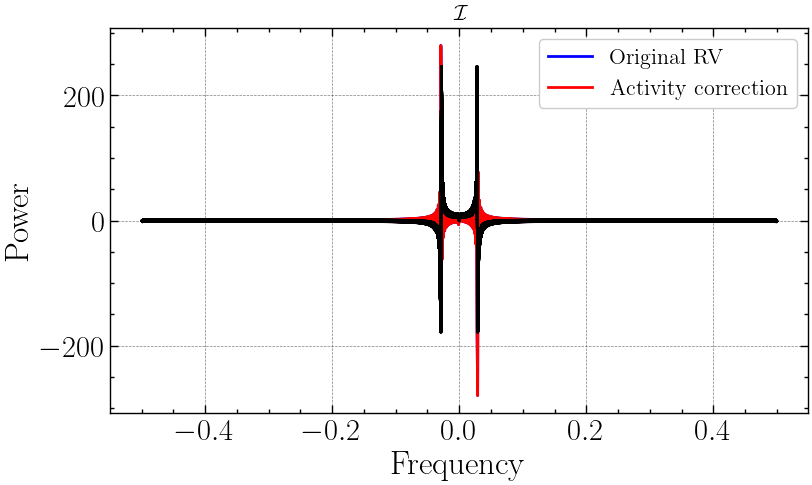

In [26]:
#compare by looking at the plots
#plot the linear regression activity model
plt.figure(figsize=(9,5))
plt.plot(fgrid, fft_val.real, color = 'b', label = 'Original RV')
plt.plot(fgrid, ac_real, color = 'r', label= 'Activity correction')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title(r'$\mathcal{R}$')
for i in range(100):
    plt.plot(fgrid, acmodel_real[i,:], color = 'k', alpha = 0.01)
plt.legend()

plt.figure(figsize=(9,5))
plt.plot(fgrid, fft_val.imag, color = 'b', label = 'Original RV')
plt.plot(fgrid, ac_imag, color = 'r', label= 'Activity correction')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title(r'$\mathcal{I}$')
for i in range(100):
    plt.plot(fgrid, acmodel_imag[i,:], color = 'k', alpha = 0.5)
plt.legend()

<ErrorbarContainer object of 3 artists>

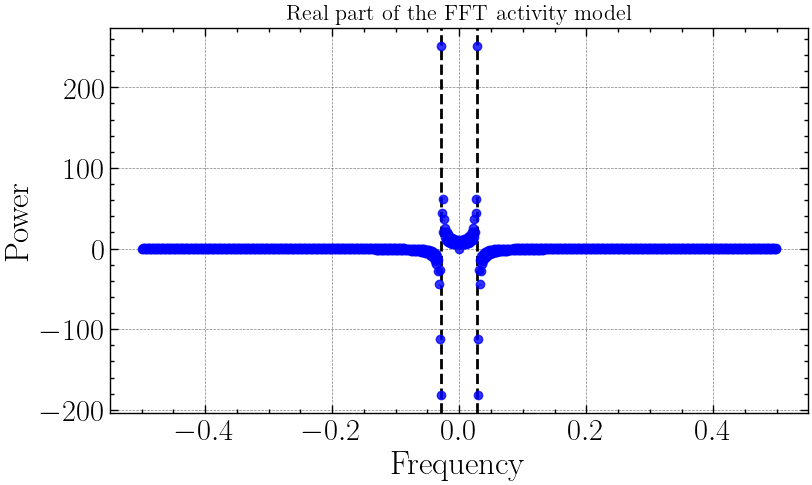

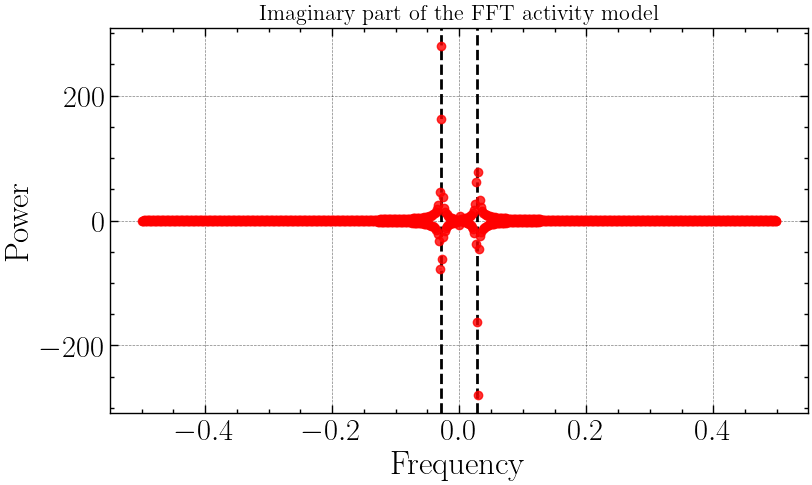

In [27]:
stdac_real = np.zeros(len(fft_val))
stdac_imag = np.zeros(len(fft_val))


for i in range(len(fft_val)):
    stdac_real[i] = np.std(acmodel_real[:,i])
    stdac_imag[i] = np.std(acmodel_imag[:,i])

plt.figure(figsize=(9,5))
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Real part of the FFT activity model')
plt.axvline(1/period, color='k', linestyle='--', label ='Period')
plt.axvline(-1/period, color='k', linestyle='--')
plt.errorbar(fgrid, ac_real ,fmt = 'o', yerr = stdac_real, color = 'b', alpha = 0.8)
#plt.fill_between(fgrid, fft_val.real - fft_err_real, fft_val.real + fft_err_real, alpha = 0.5 )

plt.figure(figsize=(9,5))
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Imaginary part of the FFT activity model')
plt.axvline(1/period, color='k', linestyle='--', label ='Period')
plt.axvline(-1/period, color='k', linestyle='--')
plt.errorbar(fgrid, ac_imag ,fmt = 'o',  yerr = stdac_imag, color = 'r', alpha = 0.8)

### Convert back to time domain

In [28]:
# convert back to time domain
FFT_ac = np.zeros_like(fft_val)
FFT_ac.real = ac_real
FFT_ac.imag = ac_imag

# FINUFFT amplitude scaling is a bit ratty, hence "raw"
activity_raw = nufft1d3(2*np.pi*fgrid, FFT_ac, time, isign=1, nthreads=1) / len(time)
print('Real part:', np.max(activity_raw.real),'--Imaginary part(should be negligible): ', np.max(activity_raw.imag))
# check that the imaginary parts are negligible

# Rescale variance using Parseval's theorem
variance_ratio = np.sum(np.abs(FFT_ac)**2) / np.sum(np.abs(fft_val)**2)

print("Raw standard deviation", f"{f_rv.std():.4f}")
print("Variance ratio:", f"{variance_ratio:.4f}")

# Make activity RVs now have unit variance
activity_scaled = (activity_raw.real - np.mean(activity_raw.real)) / np.std(activity_raw.real)
print("Variance (should be 1):", np.var(activity_scaled))

# Calculate the standard deviation of the activity signal
new_stdev = np.sqrt(variance_ratio * f_rv.var())
activity = activity_scaled * new_stdev + f_rv.mean()

Real part: 2.786133485856227 --Imaginary part(should be negligible):  1.837830716364584e-08
Raw standard deviation 21.2330
Variance ratio: 1.0000
Variance (should be 1): 0.9999999999999998


In [29]:
# do the same for the bootstrap
ffts_boot = np.zeros_like(ffts)
ffts_boot.real = acmodel_real
ffts_boot.imag = acmodel_imag

activity_boots = np.zeros((nboot,len(f_rv)))

#convert to time domain in the loop
act_boots = np.zeros((nboot, len(f_rv)), dtype = complex) #must have the same shape as the time domain
for i in range(nboot):
    act_boots[i, :] = nufft1d3(2*np.pi*fgrid, ffts_boot[i, :], time, isign=1, nthreads=1)/len(time)

#print(np.max(act_boots.real), np.max(act_boots.imag))

#use Parseval's theorem
for i in range(nboot):
    var_ratios = np.sum(np.abs(ffts_boot[i:])**2) / np.sum(np.abs(ffts)**2)
    acs_scaled = (act_boots[i,:].real - np.mean(act_boots[i:].real)) / np.std(act_boots[i,:].real)
    print("Should be 1:", np.var(acs_scaled))

    # Calculate the standard deviation of the activity signal
    boots_stdev = np.sqrt(var_ratios* (prueba[i,:]).var())
    activity_boots[i,:] = acs_scaled * boots_stdev + prueba.mean()

Should be 1: 1.0
Should be 1: 1.0
Should be 1: 1.0
Should be 1: 1.0000000000000002
Should be 1: 1.0
Should be 1: 0.9999999999999998
Should be 1: 1.0
Should be 1: 0.9999999999999998
Should be 1: 1.0
Should be 1: 1.0
Should be 1: 1.0
Should be 1: 1.0
Should be 1: 1.0
Should be 1: 0.9999999999999999
Should be 1: 1.0
Should be 1: 1.0
Should be 1: 1.0000000000000002
Should be 1: 1.0000000000000002
Should be 1: 1.0000000000000002
Should be 1: 1.0
Should be 1: 1.0
Should be 1: 1.0000000000000002
Should be 1: 1.0
Should be 1: 0.9999999999999998
Should be 1: 1.0
Should be 1: 1.0
Should be 1: 1.0
Should be 1: 1.0
Should be 1: 0.9999999999999999
Should be 1: 0.9999999999999998
Should be 1: 0.9999999999999998
Should be 1: 0.9999999999999998
Should be 1: 1.0
Should be 1: 0.9999999999999999
Should be 1: 1.0000000000000002
Should be 1: 1.0000000000000002
Should be 1: 1.0
Should be 1: 1.0
Should be 1: 1.0
Should be 1: 0.9999999999999999
Should be 1: 0.9999999999999999
Should be 1: 1.0000000000000002
S

### Not sure if this worked propperly so let's plot and check

In [30]:
std_ac = np.zeros(len(f_rv))

for i in range(len(f_rv)):
    std_ac[i] = np.std(activity_boots[:,i])

err_act = np.std(activity_boots)

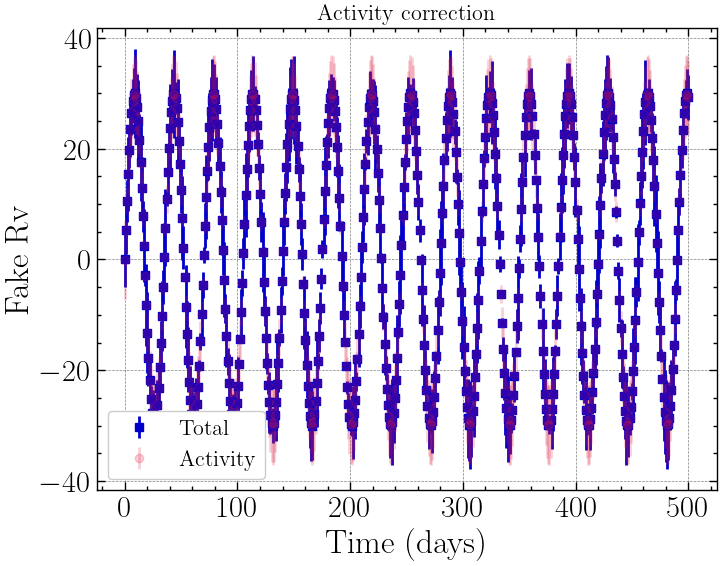

In [40]:
#activity plot
plt.figure(figsize=(8,6))
plt.errorbar(time, f_rv, yerr= f_erv, marker='s', ls='none', color='mediumblue', label='Total')
plt.errorbar(time, activity, yerr= std_ac, color='crimson', fmt = 'o', label='Activity', alpha=0.2)
#for i in range(10):
#    plt.plot(time, activity_boots[i,:], 'o', color = 'k', alpha = 0.5)
plt.xlabel('Time (days)')
plt.ylabel('Fake Rv')
plt.title('Activity correction')
#plt.ylim(-10,10)
plt.legend(loc='lower left')
#plt.ylim(5,15)
#plt.savefig('figures/activityc.png')

Looks much better! The error bars for the activity model seem to align in amplitude to the original RVs

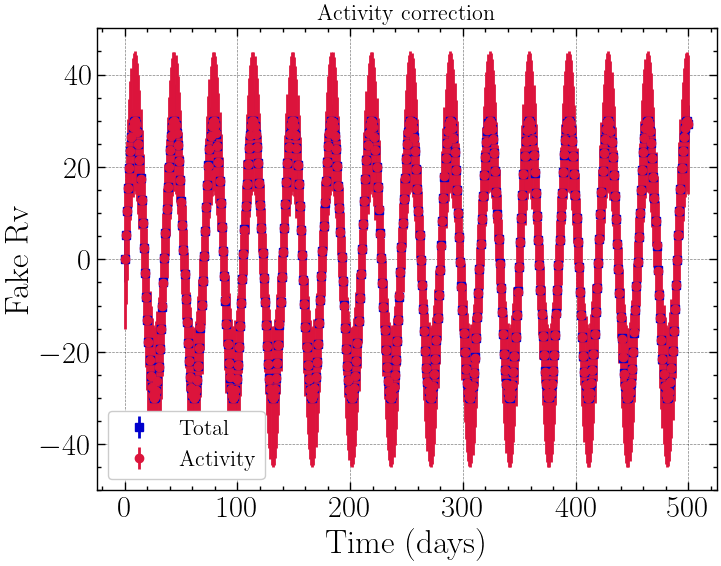

In [79]:
#acitvity plot
plt.figure(figsize=(8,6))
plt.errorbar(time, f_rv, yerr= f_erv, marker='s', ls='none', color='mediumblue', label='Total')
plt.errorbar(time, activity, yerr= err_act, color='crimson', fmt = 'o', label='Activity')
#for i in range(10):
#    plt.plot(time, activity_boots[i,:], 'o', color = 'k', alpha = 0.5)
plt.xlabel('Time (days)')
plt.ylabel('Fake Rv')
plt.title('Activity correction')
plt.ylim(-50,50)
plt.legend(loc='lower left')
#plt.ylim(5,15)

In [82]:
#compute the residual 
residuals = f_rv - activity
boot_res = prueba - activity_boots

#conver to frequency domain
res_fft = nufft1d3(2*np.pi*time, residuals.astype(complex) - np.mean(residuals), fgrid, \
                                      isign=-1, nthreads=1)

boot_res_fft = np.zeros((nboot,len(res_fft)), dtype = complex)
for i in range(nboot):
    boot_res_fft[i, :] = nufft1d3(2*np.pi*time, boot_res[i, :].astype(complex) - boot_res[i,:].mean(), fgrid, isign=-1, nthreads=1)


#### Generate the periodogram plot

In [83]:
error_per = np.zeros(len(res_fft))

for i in range(len(f_rv)):
    error_per[i] = np.std(boot_res[:,i])

error_per = np.std(np.abs(boot_res_fft)**2)

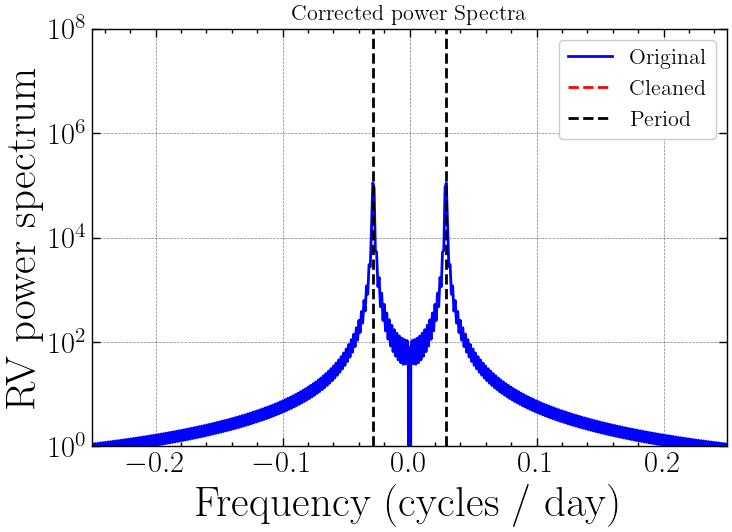

In [85]:
plt.figure(figsize=(8,6))
#plt.plot(fgrid, np.abs(fft_val)**2, label='Total', color='mediumblue', alpha = 0.5)
plt.plot(fgrid,np.abs(fft_val)**2, color = 'b', label= 'Original')
plt.plot(fgrid, np.abs(res_fft)**2,'--', label='Cleaned', color='r')
plt.fill_between(fgrid, np.abs(res_fft)**2 - error_per, np.abs(res_fft)**2 + error_per, alpha = 0.2, color = 'r', \
                 where = np.abs(res_fft)**2 - error_per >0)
plt.xlim(-0.25,0.25)
plt.yscale('log')
plt.ylim([1,1e8])
plt.xlabel('Frequency (cycles / day)', fontsize='large')
plt.ylabel( 'RV power spectrum', fontsize='large')
plt.title('Corrected power Spectra', fontsize =16)
plt.axvline(1/period, color='k', linestyle='--', label ='Period')
plt.axvline(-1/period, color='k', linestyle='--')
plt.legend(loc='best')
plt.tight_layout()
#plt.xlim(0, 0.4)
#plt.ylim(1, 10e4)

#### it sort of looks like it works

Not sure why some of the error estimates go so low though, I am assuming because some of the values go much smaller than 0

## Try with some real data

In [86]:
haydata = pd.read_csv('data/CoRoT-7_Haywood14_spec.txt', sep = '\t', skiprows = 7)
haydata.columns = ['JDB', 'RV', 'e_RV', 'FWHM', 'BIS', "log(R'(HK))", "e_log(R'(HK))"]
haydata.head()

,JDB,RV,e_RV,FWHM,BIS,log(R'(HK)),e_log(R'(HK))
0,2.455940e+06,31.18031,0.00233,6.45633,0.01199,4.6990,0.0180
1,2.455940e+06,31.17814,0.00212,6.46445,0.01966,4.7188,0.0173
2,2.455941e+06,31.18283,0.00251,6.46592,0.01956,4.6982,0.0210
3,2.455941e+06,31.17833,0.00271,6.45650,0.03679,4.7789,0.0283
4,2.455941e+06,31.18415,0.00215,6.46568,0.01359,4.7204,0.0180


In [87]:
#change units
haydata['shifted_JD'] = haydata['JDB'] - haydata.iloc[0]['JDB']
haydata['RV'] = (haydata['RV'] - np.mean(haydata['RV']))*1000
haydata['e_RV'] = haydata['e_RV']*1000

Text(0.5, 1.0, 'RV CoRoT-7 Haywood et. al (2014)')

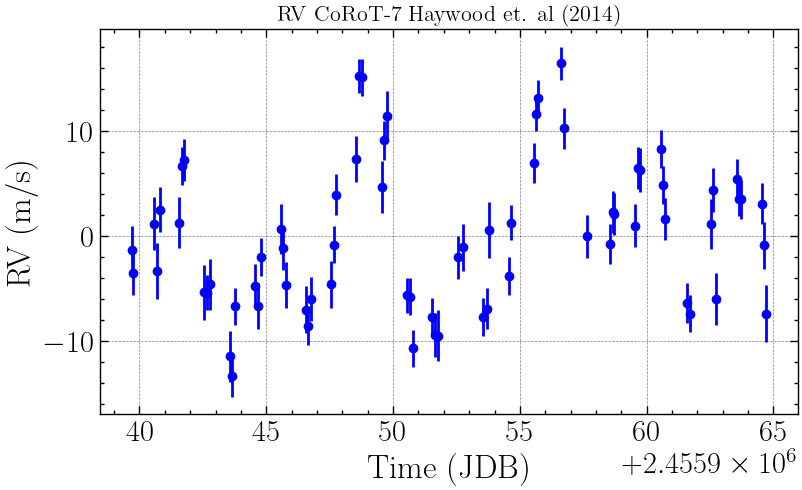

In [88]:
plt.figure(figsize = (9,5))
plt.errorbar(haydata['JDB'], haydata['RV'], yerr = haydata['e_RV'], fmt = 'o', color = 'b')
plt.ylabel('RV (m/s)')
plt.xlabel('Time (JDB)')
plt.title('RV CoRoT-7 Haywood et. al (2014)', fontsize = 16)

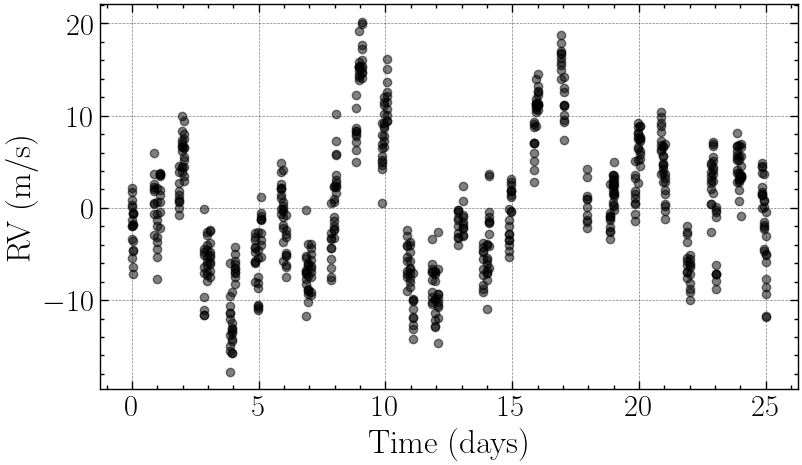

In [89]:
time = np.array(haydata['shifted_JD'])
rv = np.array(haydata['RV'])
rv_err = np.array(haydata['e_RV'])
#it is very important to turn them into numpy arrays!! other wise the index messes everything up

nboot = 1000
samples = np.random.normal(size = (nboot, len(rv))) *rv_err + rv
samples = samples.T #transpose the matrix so that each column is a different time series

plt.figure(figsize=(9,5)) #plot only ten of them
plt.xlabel('Time (days)')
plt.ylabel('RV (m/s)')
for i in range(10):
    plt.plot(time, samples[:, i], 'o', color = 'k', alpha = 0.5)

In [ ]:
rv_scaled = 

### FFTs

In [133]:
nyq = 0.5/np.mean(np.diff(time))
maxf = 2* nyq      # Maximum frequency is 2x the Nyquist frequency
nr = len(time)
nf = 2*nr + 1
fgrid = np.linspace(-maxf, maxf, num= nf, endpoint=True)
fft_rv = nufft1d3(2*np.pi*time, rv - rv.mean(), fgrid, isign=-1, nthreads=1)

In [134]:
ffts = np.zeros((len(fft_rv), nboot), dtype = complex)
for i in range(nboot):
    ffts[:, i] = nufft1d3(2*np.pi*time, samples[:, i] - samples[:,i].mean(), fgrid, isign=-1, nthreads=1)

<ErrorbarContainer object of 3 artists>

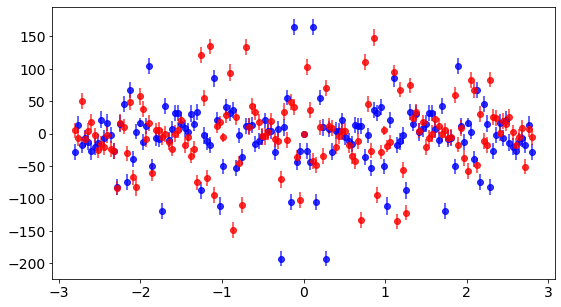

In [138]:
#estimate errors
fft_err_real = np.std(ffts.real, axis = 1)
fft_err_imag = np.std(ffts.imag, axis = 1)
plt.figure(figsize=(9,5))
plt.errorbar(fgrid, fft_rv.real ,fmt = 'o', yerr = fft_err_real, color = 'b', alpha = 0.8)
#plt.fill_between(fgrid, fft_val.real - fft_err_real, fft_val.real + fft_err_real, alpha = 0.5 )
plt.errorbar(fgrid, fft_rv.imag,fmt = 'o',  yerr = fft_err_imag, color = 'r', alpha = 0.8)

### Perform the FFT on the activity indicators

In [147]:
names = ['RV', 'FWHM', 'BIS', 'log(R\'(HK))']
losff = []
for i in range(len(names)):
        fval = nufft1d3(2*np.pi*time, haydata[names[i]] - haydata[names[i]].mean(), \
                fgrid, isign=-1, nthreads=1)
        losff.append(fval)

In [150]:
fftfram = pd.DataFrame()
fftfram['frequency'] = fgrid
for i in range(1,len(losff)):
            cname = names[i]
            fftfram[cname+" re"] = losff[i].real 
            fftfram[cname+" im"] = losff[i].imag 

In [151]:
fftfram.head()

,frequency,FWHM re,FWHM im,BIS re,BIS im,log(R'(HK)) re,log(R'(HK)) im
0,-2.799539,-0.027239,-0.027447,-0.032439,0.008705,-0.136602,-0.065465
1,-2.760109,0.020501,-0.016666,-0.044480,-0.094717,-0.039265,0.057854
2,-2.720678,0.090775,0.031695,-0.079096,0.025630,-0.072000,-0.182105
3,-2.681248,0.023033,0.010604,-0.000953,0.032362,-0.177743,-0.128309
4,-2.641818,0.011006,-0.019534,-0.032435,-0.011837,0.131321,-0.154071


In [153]:
scaled = StandardScaler().fit_transform(fftfram.iloc[:,1:])

In [154]:
#perform the fft of the actual data
reg_real = linear_model.LinearRegression()
reg_real.fit(scaled, fft_rv.real)
ac_real = reg_real.predict(scaled)
print('Real')
print('----')
print('Intercept: \n', reg_real.intercept_)
print('Coefficients: \n', reg_real.coef_)

reg_imag = linear_model.LinearRegression()
reg_imag.fit(scaled, fft_rv.imag)
ac_imag = reg_imag.predict(scaled)
print('Imaginary')
print('----')
print('Intercept: \n', reg_imag.intercept_)
print('Coefficients: \n', reg_imag.coef_)

Real
----
Intercept: 
 -4.185494368532588
Coefficients: 
 [ 2.54678921e+01 -1.13493410e-08 -2.59848086e+00  3.43918704e-08
  2.92232680e+00 -5.09091583e-09]
Imaginary
----
Intercept: 
 1.9643036933298936e-08
Coefficients: 
 [-3.52543607e-08  2.52634983e+01  5.50611112e-09 -2.75149580e+00
 -2.23207657e-08  1.04837397e+00]


In [155]:
#now do it for the bootstrap
#real
boot_reg_real = linear_model.LinearRegression().fit(scaled, ffts.real)
inte_real_err = np.std(boot_reg_real.intercept_)
coef_real_err = np.std(boot_reg_real.coef_, axis = 0)
ac_boot_real = boot_reg_real.predict(scaled)
print('Real')
print('-----')
print('Standard deviation in intercept:\n', inte_real_err)
print('Standar deviation for each coefficeint:\n', coef_real_err, '\n')


#imaginary
boot_reg_imag = linear_model.LinearRegression().fit(scaled, ffts.imag)
inte_imag_err = np.std(boot_reg_imag.intercept_)
coef_imag_err = np.std(boot_reg_imag.coef_, axis = 0)
ac_boot_imag = boot_reg_imag.predict(scaled)
print('Imaginary')
print('-----')
print('Standard deviation in intercept:\n', inte_imag_err)
print('Standard deviation in each coefficient:\n', coef_imag_err)

Real
-----
Standard deviation in intercept:
 2.8675939589358044
Standar deviation for each coefficeint:
 [2.31912265e+00 1.80320682e-08 1.87581439e+00 1.96001942e-08
 2.12481491e+00 1.78468435e-08] 

Imaginary
-----
Standard deviation in intercept:
 2.687957596323091e-08
Standard deviation in each coefficient:
 [1.95231028e-08 2.34084111e+00 6.82805059e-09 1.87965279e+00
 1.41885493e-08 2.10273797e+00]


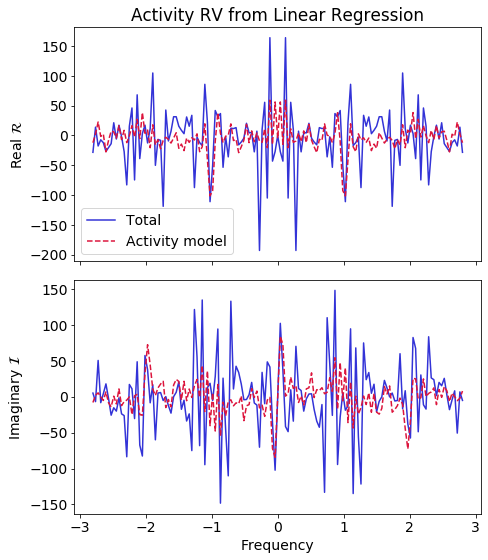

In [156]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7,8))
ax1.plot(fgrid, fft_rv.real, label="Total ", color='mediumblue', alpha = 0.8)
ax1.plot(fgrid, ac_real, '--', label="Activity model", color='crimson')
ax1.legend(loc="best")
ax1.set_ylabel(r"Real $\mathcal{R}$")
ax1.set_title("Activity RV from Linear Regression")
ax2.plot(fgrid, fft_rv.imag, color='mediumblue', alpha = 0.8)
ax2.plot(fgrid, ac_imag, '--', color='crimson')
ax2.set_ylabel(r"Imaginary $\mathcal{I}$")
ax2.set_xlabel("Frequency")
plt.tight_layout()

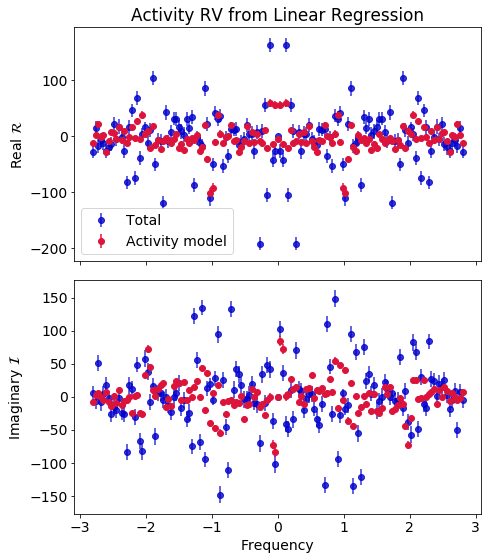

In [157]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7,8))
ax1.errorbar(fgrid, fft_rv.real, yerr= fft_err_real ,fmt = 'o' , label="Total ", color='mediumblue', alpha = 0.8)
ax1.errorbar(fgrid, ac_real, yerr=np.std(ac_boot_real, axis =1), fmt= 'o', label="Activity model", color='crimson')
ax1.legend(loc="best")
ax1.set_ylabel(r"Real $\mathcal{R}$")
ax1.set_title("Activity RV from Linear Regression")
ax2.errorbar(fgrid, fft_rv.imag, yerr = fft_err_imag, fmt= 'o', color='mediumblue', alpha = 0.8)
ax2.errorbar(fgrid, ac_imag, yerr= np.std(ac_boot_imag, axis =1), fmt= 'o', color='crimson')
ax2.set_ylabel(r"Imaginary $\mathcal{I}$")
ax2.set_xlabel("Frequency")
plt.tight_layout()

In [159]:
# convert back to time domain
FFT_ac = np.zeros_like(fft_rv)
FFT_ac.real = ac_real
FFT_ac.imag = ac_imag

# FINUFFT amplitude scaling is a bit ratty, hence "raw"
activity_raw = nufft1d3(2*np.pi*fgrid, FFT_ac, time, isign=1, nthreads=1) / len(time)
print(np.max(activity_raw.real), np.max(activity_raw.imag)) # check that the imaginary parts are negligible

# Rescale variance using Parseval's theorem
variance_ratio = np.sum(np.abs(FFT_ac)**2) / np.sum(np.abs(fft_rv)**2)

print("Raw standard deviation", f"{rv.std():.4f}")
print("Variance ratio:", f"{variance_ratio:.4f}")

# Make activity RVs now have unit variance
activity_scaled = (activity_raw.real - np.mean(activity_raw.real)) / np.std(activity_raw.real)
print("Should be 1:", np.var(activity_scaled))

# Calculate the standard deviation of the activity signal
new_stdev = np.sqrt(variance_ratio * rv.var())
activity = activity_scaled * new_stdev + rv.mean()

23.727511484812442 8.535616477515222e-08
Raw standard deviation 6.8582
Variance ratio: 0.2287
Should be 1: 1.0


In [160]:
# do the same for the bootstrap
ffts_boot = np.zeros_like(ffts)
ffts_boot.real = ac_boot_real
ffts_boot.imag = ac_boot_imag

#convert to time domain in the loop
act_boots = np.zeros((len(rv), nboot), dtype = complex) #must have the same shape as the time domain
for i in range(nboot):
    act_boots[:, i] = nufft1d3(2*np.pi*fgrid, ffts_boot[:, i], time, isign=1, nthreads=1)/len(time)

#print(np.max(act_boots.real), np.max(act_boots.imag))

#use Parseval's theorem
var_ratios = np.sum(((np.abs(ffts_boot))**2), axis = 0) / np.sum(np.abs(ffts)**2, axis =0)
print("Raw standard deviation", f"{f_rv.std():.4f}")
print("Variance ratio:", f"{var_ratios}")

# Make activity RVs now have unit variance
acs_scaled = (act_boots.real - np.mean(act_boots.real, axis = 0)) / np.std(act_boots.real, axis = 0)
print("Should be 1:", np.var(acs_scaled, axis = 0))

# Calculate the standard deviation of the activity signal
boots_stdev = np.sqrt(var_ratios*prueba.var(axis =0))
activity_boots = acs_scaled * boots_stdev + samples.mean(axis=0)

Raw standard deviation 5.7968
Variance ratio: [0.20883873 0.21005311 0.216617   0.24708949 0.18699178 0.16717171
 0.21629704 0.20315257 0.19376397 0.19984407 0.18862607 0.27140072
 0.27510925 0.19081684 0.21986704 0.22561973 0.24843185 0.23473765
 0.23658693 0.24012791 0.23161012 0.24077741 0.24013285 0.22438081
 0.15850857 0.21616758 0.20959001 0.20577822 0.25333944 0.22347018
 0.27798204 0.28411678 0.20888649 0.27460574 0.25525208 0.24436245
 0.15369651 0.21469218 0.20503249 0.19992565 0.20774344 0.21734044
 0.19427263 0.21763512 0.18164004 0.19924102 0.20584071 0.12649281
 0.17453944 0.22808641 0.2315116  0.17812025 0.20288045 0.2139749
 0.22654152 0.27845251 0.18332471 0.16760534 0.26094462 0.19388382
 0.19039286 0.21052269 0.25574286 0.2169086  0.22576482 0.24227592
 0.18523104 0.25486855 0.26054172 0.21339224 0.23440277 0.23750958
 0.21648791 0.2052483  0.24104355 0.20566725 0.30517316 0.15945761
 0.15868519 0.22396    0.23285339 0.2377359  0.26753491 0.22198398
 0.28059524 0.181

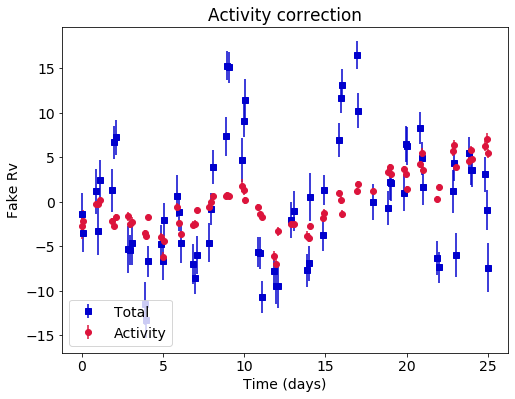

In [161]:
err_act = np.std(activity_boots, axis = 1)
#acitvity plot
plt.figure(figsize=(8,6))
plt.errorbar(time, rv, yerr= rv_err, marker='s', ls='none', color='mediumblue', label='Total')
plt.errorbar(time, activity, yerr= err_act, color='crimson', fmt = 'o', label='Activity')
plt.xlabel('Time (days)')
plt.ylabel('Fake Rv')
plt.title('Activity correction')
plt.legend(loc='lower left')
#plt.ylim(5,15)

In [162]:
#compute the residual 
residuals = rv - activity
boot_res = samples - activity_boots

#conver to frequency domain
res_fft = nufft1d3(2*np.pi*time, residuals - np.mean(residuals), fgrid, \
                                      isign=-1, nthreads=1)

boot_res_fft = np.zeros((len(res_fft), nboot), dtype = complex)
for i in range(nboot):
    boot_res_fft[:, i] = nufft1d3(2*np.pi*time, boot_res[:, i] - boot_res[:,i].mean(), fgrid, isign=-1, nthreads=1)


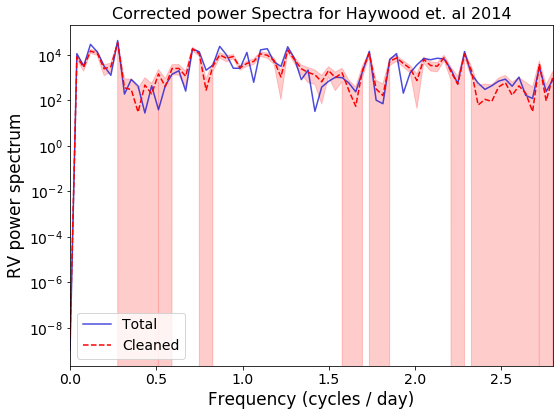

In [170]:
error_per = np.std(np.log10(np.abs(boot_res_fft)**2), axis = 1)
plt.figure(figsize=(8,6))
plt.plot(fgrid, np.abs(fft_rv)**2, label='Total', color='mediumblue', alpha = 0.7)
plt.plot(fgrid, np.abs(res_fft)**2,'--', label='Cleaned', color='r')
plt.fill_between(fgrid, np.abs(res_fft)**2 - error_per, np.abs(res_fft)**2 + error_per, alpha = 0.2, color = 'r')
plt.xlim([0,fgrid[-1]])
plt.yscale('log')
# plt.ylim([10,100000])
plt.xlabel('Frequency (cycles / day)', fontsize='large')
plt.ylabel( 'RV power spectrum', fontsize='large')
plt.title('Corrected power Spectra for Haywood et. al 2014', fontsize =16)
plt.legend(loc='best')
plt.tight_layout()
#plt.xlim(0, 0.4)
#plt.ylim(1, 10e4)
plt.savefig('confi_periodogram.png')

### It's looking great so far!!
There are still some things I want to check but I think this is a good start